This notebook runs the list-learning behavioral analyses

## Import libraries

In [2]:
!pip install git+https://github.com/ContextLab/quail@b8b332a --upgrade

  Cloning https://github.com/ContextLab/quail (to b8b332a) to /tmp/pip-kr88vvpw-build
  Could not find a tag or branch 'b8b332a', assuming commit.
Requirement already up-to-date: numpy>=1.10.4 in /opt/conda/lib/python3.6/site-packages (from quail==0.2.0)
Requirement already up-to-date: scipy>=0.17.1 in /opt/conda/lib/python3.6/site-packages (from quail==0.2.0)
Requirement already up-to-date: matplotlib>=1.5.1 in /opt/conda/lib/python3.6/site-packages (from quail==0.2.0)
Requirement already up-to-date: seaborn>=0.9.0 in /opt/conda/lib/python3.6/site-packages (from quail==0.2.0)
Requirement already up-to-date: pandas>=0.18.1 in /opt/conda/lib/python3.6/site-packages (from quail==0.2.0)
Requirement already up-to-date: future in /opt/conda/lib/python3.6/site-packages (from quail==0.2.0)
Requirement already up-to-date: six in /opt/conda/lib/python3.6/site-packages (from quail==0.2.0)
Requirement already up-to-date: deepdish in /opt/conda/lib/python3.6/site-packages (from quail==0.2.0)
Requi

In [3]:
import quail
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
from scipy.spatial.distance import cdist
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Settings and parameters

In [18]:
matplotlib.rcParams['pdf.fonttype'] = 42
datadir = '/data/processed/'
palette = 'bone'

## Load data

In [19]:
video_events = np.load(datadir+'video_events_wasserstein.npy')
recall_events = np.load(datadir+'recall_events_wasserstein.npy')

## Convert to egg format

In [20]:
pres = [[[{'item' : i, 'topics' : m} for i, m in enumerate(video_events)]] for sub in range(17)]

rec = []
for r in recall_events:
    items = list(np.argmax(1 - cdist(video_events, r), 0).astype(int))
    rec.append([[{'item' : item, 'topics' : t} for item, t in zip(items, r)]])

## Make the egg

In [21]:
egg = quail.Egg(pres=pres, rec=rec)
egg.info()

Number of subjects: 17
Number of lists per subject: 1
Number of words per list: 20
Date created: Wed Feb  6 14:34:50 2019
Meta data: {}


## Run probability of first recall, lagcrp and serial position curve analyses, and create a figure

/opt/conda/lib/python3.6/site-packages/quail/analysis/recmat.py:106: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, 1)
/opt/conda/lib/python3.6/site-packages/quail/analysis/lagcrp.py:129: RuntimeWarning: Mean of empty slice
  return np.nanmean(lagcrp, axis=0)


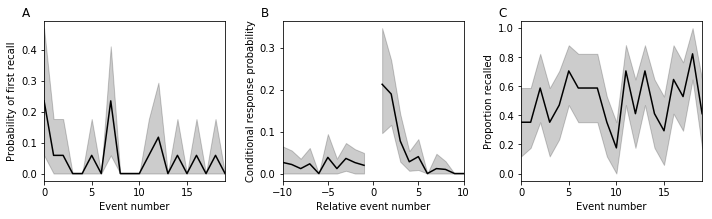

In [30]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(10, 3)

analysis = ['pfr', 'lagcrp', 'spc']
res = {}
for ax, a in zip(axarr, analysis):
    res[a] = egg.analyze(a, match='best', features=['topics'], 
                distance='correlation')
    res[a].plot(show=False, ax=ax, legend=False, palette=palette)
        
# make some adjustments
axarr[1].set_xlim(-10, 10)
axarr[0].set_ylabel('Probability of first recall')
axarr[1].set_ylabel('Conditional response probability')
axarr[2].set_ylabel('Proportion recalled')
axarr[0].set_xlabel('Event number')
axarr[1].set_xlabel('Relative event number')
axarr[2].set_xlabel('Event number')
plt.subplots_adjust(wspace=.45, hspace=.75)
plt.tight_layout()

# add labels
label=['A', 'B', 'C']
for p, l in zip(axarr, label):
    p.text(-.1,1.025,l,
        horizontalalignment='center',
        transform=p.transAxes,
          fontsize=12)
# plt.savefig('../figures/list_learning.pdf')
plt.savefig('/mnt/list_learning_wasserstein.pdf')
plt.show()

## Cluster analyses

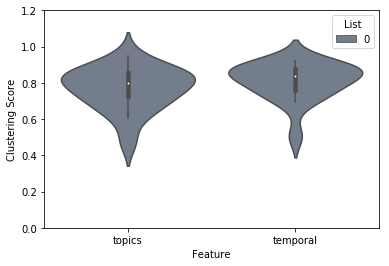

In [23]:
clustering = egg.analyze('fingerprint')
clustering.plot(ylim=[0, 1.2], palette=palette)

## SEM of clustering scores

In [24]:
sem = clustering.get_data().std() / np.sqrt(17)
print(clustering.get_data().mean())
print(sem)
print(clustering.get_data().mean() + sem)
clustering.get_data().mean() - sem

topics      0.767400
temporal    0.808662
dtype: float64
topics      0.028281
temporal    0.025004
dtype: float64
topics      0.795681
temporal    0.833667
dtype: float64


topics      0.739119
temporal    0.783658
dtype: float64

## Create a dataframe containing the analysis results

In [25]:
ks = np.array([8, 14, 11, 9, 14, 10, 17, 17, 10, 20, 19, 25, 27, 14, 10, 14, 23])
hand_rec = np.array([27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39])
auto_rec = res['spc'].data.mean(1).values
df = pd.DataFrame(np.array([clustering.data.temporal.values, clustering.data.topics.values, ks, hand_rec, auto_rec]).T, 
                  columns=['Temporal clustering', 'Semantic clustering', 'Number of events (k)', 'Memory performance - hand', 
                           'Memory performance - auto'])

## Correlation between hand annotated memory and memory estimated from the model across subjects

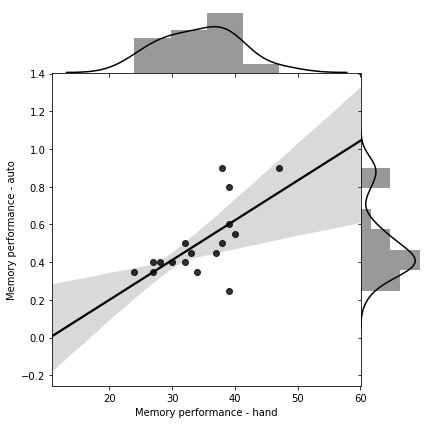

In [26]:
sns.jointplot(x=df['Memory performance - hand'], y=df['Memory performance - auto'], kind='reg', 
              space=False, color='k')

## Correlation between hand annotated memory and k (number of events) across subjects

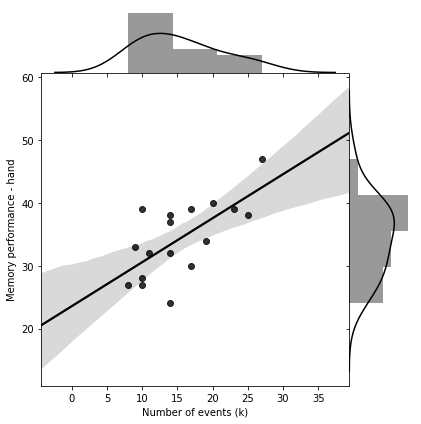

In [27]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Number of events (k)'], kind='reg', space=False, color='k')

## Correlation between hand annotated memory and temporal clustering

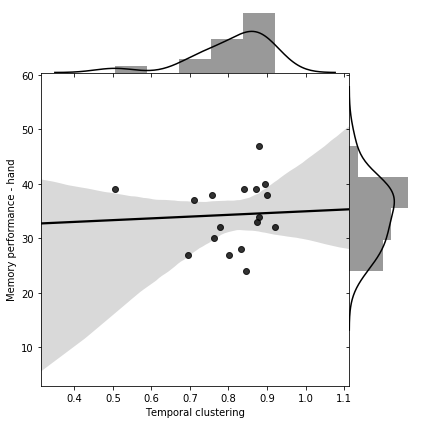

In [28]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Temporal clustering'], kind='reg', space=False, color='k')

## Correlation between hand annotated memory and semantic clustering

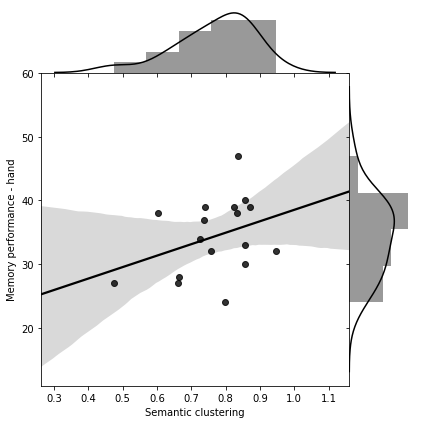

In [29]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Semantic clustering'], kind='reg', space=False, color='k')